In [1]:
import text
import ascii

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

import pandas as pd
pd.set_option("display.max_columns", None)

In [2]:
def encoding(file):
    input = open(file)

    for line in input:
        row = list(line)

        for index in range(len(row)):
            row[index] = ord(row[index])

            if row[index] == 32: row[index] = 34 # " "
            else: row[index] = row[index] - 96

    input.close()
    return row

In [3]:
def decoding(group):
    for index in range(len(group)):
        if group[index] == 34: group[index] = 32 # " "
        else: group[index] = group[index] + 96
        
        group[index] = chr(group[index])

    return group

In [4]:
def shifting(group,alphabet,key):
    index = 0
    while(index < len(group)):
        group[index] = alphabet[(alphabet.index(group[index]) - key) % len(alphabet)] 
        index += 1

    return group

In [2]:
def alphabet_creation(language, key):
    if language == "ENG: 1984":    
        alphabet = "abcdefghijklmnopqrstuvwxyz"
    if language == "UKR: misto":    
        alphabet = "абвгдежзийклмнопрстуфхцчшщґїьєюяі"

    alphabet = list(alphabet)

    shifted_alphabet = [] 
    index = 0
    while(index < len(alphabet)):
        shifted_alphabet.append(alphabet[(index + key) % len(alphabet)]) 
        index += 1

    unshifted_alphabet = [] 
    index = 0
    while(index < len(alphabet)):
        unshifted_alphabet.append(alphabet[(index - key) % len(alphabet)]) 
        index += 1

    return alphabet, shifted_alphabet, unshifted_alphabet

In [3]:
def text_processing(language, alphabet, key):
    if language == "ENG: 1984":
        text.remove_extra("1984 chapters III-VIII: input.txt", "1984 chapters III-VIII: cleaned.txt")

        removed_spaces = text.remove_spaces("1984 chapters III-VIII: cleaned.txt", "1984 chapters III-VIII: extra cleaned.txt")

        text.encrypt("1984 chapters III-VIII: extra cleaned.txt", "1984 chapters III-VIII: encrypted.txt", alphabet, key)

        y_pure = encoding("1984 chapters III-VIII: extra cleaned.txt") # convertion from letters to enumerated states
        y_ciphered = encoding("1984 chapters III-VIII: encrypted.txt")

    else: # language == "UKR: misto"    
        text.remove_extra("misto chapters IV-X: input.txt", "misto chapters IV-X: cleaned.txt")

        removed_spaces = text.remove_spaces("misto chapters IV-X: cleaned.txt", "misto chapters IV-X: extra cleaned.txt")

        text.encrypt("misto chapters IV-X: extra cleaned.txt", "misto chapters IV-X: encrypted.txt", alphabet, key)

        y_pure = ascii.encoding("misto chapters IV-X: extra cleaned.txt") # convertion from letters to enumerated states
        y_ciphered = ascii.encoding("misto chapters IV-X: encrypted.txt")

    return y_pure, y_ciphered, removed_spaces

- __матриця A__

In [4]:
def A_creation(language, alphabet):
    A = np.zeros((len(alphabet), len(alphabet)))

    if language == "ENG: 1984":    
        A = text.count("1984 chapters III-VIII: extra cleaned.txt", alphabet, A)
    else: # language == "UKR: misto"    
        A = text.count("misto chapters IV-X: extra cleaned.txt", alphabet, A)   

    for i in range(len(A)):
        scaler = np.sum(A[i]+5)
        for j in range(len(A)):
            A[i][j] = (A[i][j]+5)/scaler

    return A

- __матриця B__

In [49]:
def dataframe(matrix, alphabet):
    dictionary = {}
    for j in range(len(matrix)):
        dictionary[j] = [round(matrix[i][j],2) for i in range(len(matrix[0]))] 
    df = pd.DataFrame(dictionary)
    fancy_df = pd.DataFrame(dictionary.values(), columns=list(alphabet), index=list(alphabet))

    return df, fancy_df

In [6]:
def persent(language, B, alphabet, shifted_alphabet, unshifted_alphabet):
    if language == "ENG: 1984":
        encrypted_alphabet = []

        # check by rows: a->d, b->e, c->f
        for i in range(len(B)):
            encrypted_alphabet.append("".join(decoding([np.argmax(B[i])+1])))

        count = 0
        for i in range(len(alphabet)):
            if shifted_alphabet[i] == encrypted_alphabet[i]:
                count += 1

        persent_by_rows = round(count/len(alphabet),2)

        print("origin            :", "".join(alphabet))
        print("shifted_alphabet  :", "".join(shifted_alphabet))
        print("encrypted_alphabet:", "".join(encrypted_alphabet))

    else: # language == "UKR: misto":
        encrypted_alphabet = []

        # check by rows: a->d, b->e, c->f
        for i in range(len(B)):
            encrypted_alphabet.append("".join(ascii.decoding([np.argmax(B[i])+1])))

        count = 0
        for i in range(len(alphabet)):
            if shifted_alphabet[i] == encrypted_alphabet[i]:
                count += 1

        persent_by_rows = round(count/len(alphabet),2)

        print("origin            :", "".join(alphabet))
        print("shifted_alphabet  :", "".join(shifted_alphabet))
        print("encrypted_alphabet:", "".join(encrypted_alphabet))

    return persent_by_rows

In [46]:
def B_creation(alphabet, real_vowels, real_consonants, fake_vowels, fake_consonants, type):
    B = np.zeros((len(alphabet),len(alphabet)))
    
    if type == "vowels-consonants":
        for i in real_vowels:
            for j in fake_vowels:
                B[i][j] = 1/len(fake_vowels) + random.uniform(-0.0001, 0.0001)

        for i in real_consonants:
            for j in fake_consonants:
                B[i][j] = 1/len(fake_consonants) + random.uniform(-0.0001, 0.0001)

        for i in range(len(B)):
            scaler = np.sum(B[i])
            for j in range(len(B[0])):
                B[i][j] = B[i][j]/scaler
    
    if type == "ones":
        for i in range(len(B)):
            for j in range(len(B[0])):
                if j == (i+3) % len(alphabet):
                    B[i][j] = 0.9 + random.uniform(-0.01, 0.01)
                else: 
                    B[i][j] = 0.001 + random.uniform(-0.001, 0.001)
        
        for i in range(len(B)):
            scaler = np.sum(B[i])
            for j in range(len(B[0])):
                B[i][j] = B[i][j]/scaler
    
    if type == "uniform":
        for i in range(len(B)):
            for j in range(len(B[0])):
                B[i][j] = 1/len(fake_consonants) + random.uniform(-0.01, 0.01)

        for i in range(len(B)):
            scaler = np.sum(B[i])
            for j in range(len(B[0])):
                B[i][j] = B[i][j]/scaler

    return B

In [11]:
# example ["а","б","в","г","д","е"]

# print(B_creation([ "а","б","в","г","д","е"], 
#                  [0,5], [1,2,3,4], [2,3], [0,1,4,5],
#                  type="ones")) # vowels-consonants, ones, uniform

- __вектор m__

In [8]:
def m_creation(alphabet, A, type):
    if type == "uniform":
        counter = 0
        while (counter < 1):
            m = np.array([random.choice([-1,1])*0.0001+1/len(alphabet) for j in range(len(alphabet)-1)])
            m = np.append(m, 1-np.sum(m))

            if m[len(alphabet)-1] > 0: 
                counter += 1
    if type == "stationary":
        # note: the matrix is row stochastic. A markov chain transition will correspond to left multiplying by a row vector

        # We have to transpose so that Markov transitions correspond to right multiplying by a column vector. 
        # np.linalg.eig finds right eigenvectors

        evals, evecs = np.linalg.eig(A.T)
        evec1 = evecs[:,np.isclose(evals, 1)]

        # Since np.isclose will return an array, we've indexed with an array, so we still have our 2nd axis.  Get rid of it, since it's only size 1
        evec1 = evec1[:,0]

        m = evec1 / evec1.sum()

        # eigs finds complex eigenvalues and eigenvectors, so you'll want the real part
        m = m.real

    return m

- __Алгоритм Баума-Велша__

In [9]:
def alpha_calculation(y,m,A,B):
    time = len(y)
    alpha = [[0.0 for i in range(len(B))] for t in range(time)]
    scaler = [0.0 for t in range(time)]

    for t in range(time):
        for i in range(len(B)):
            if t == 0: 
                alpha[t][i] = m[i]*B[i][y[t]-1]
                scaler[t] += alpha[t][i]
            else:
                aA = 0
                for j in range(len(B)):
                    aA += alpha[t-1][j]*A[j][i]
                alpha[t][i] = aA*B[i][y[t]-1]
                scaler[t] += alpha[t][i]
        
        for i in range(len(B)):
            alpha[t][i] = alpha[t][i]/scaler[t]

    P = 0
    for t in range(time):
        P += np.log(scaler[t]) 

    return alpha, -P, scaler

In [10]:
def beta_calculation(y,m,A,B, scaler):
    time = len(y)
    beta = [[0.0 for i in range(len(B))] for t in range(time)]

    for t in range(time-1, -1, -1):
        for i in range(len(B)):
            if t == time-1: 
                beta[t][i] = 1
            else:
                bAB = 0
                for j in range(len(B)):
                    bAB += beta[t+1][j]*A[i][j]*B[j][y[t+1]-1]
                beta[t][i] = bAB

        for i in range(len(B)):
            beta[t][i] = beta[t][i]/scaler[t]

    return beta

In [11]:
def gamma(y,A,B,alpha,beta):
    time = len(y)
    gamma_i = [[0.0 for i in range(len(B))] for t in range(time)]

    for t in range(time):
        denominator = 0
        for i in range(len(B)):
            denominator += alpha[t][i]*beta[t][i]
        for i in range(len(B)):
            gamma_i[t][i] = alpha[t][i]*beta[t][i]/denominator

    gamma_ij = [[[0.0 for j in range(len(B))] for i in range(len(B))] for t in range(time-1)]

    for t in range(time-1):
        sum_i = 0
        for i in range(len(B)):
            sum_j = 0
            for j in range(len(B)):
                sum_j += alpha[t][i]*A[i][j]*B[j][y[t+1]-1]*beta[t+1][j]
            sum_i += sum_j

        for i in range(len(B)):
            for j in range(len(B)):
                gamma_ij[t][i][j] = alpha[t][i]*A[i][j]*B[j][y[t+1]-1]*beta[t+1][j]/sum_i

    return gamma_i, gamma_ij

In [12]:
def reestimation(y,gamma_i,gamma_ij,*args):
    time = len(y)

    if (len(args) == 3):
        for i in range(len(args[2])):
            args[0][i] = gamma_i[0][i]

        for i in range(len(args[2])):
            for j in range(len(args[2])):
                sum_i, sum_ij = 0, 0
                for t in range(time-1):
                    sum_ij += gamma_ij[t][i][j]
                    sum_i += gamma_i[t][i]
                args[1][i][j] = sum_ij/sum_i

        for j in range(len(args[2])):
            for k in range(len(args[2][0])):
                sum_up, sum_down = 0, 0
                for t in range(time):
                    if y[t] == k+1: sum_up += gamma_i[t][j]
                    sum_down += gamma_i[t][j]
                args[2][j][k] = sum_up/sum_down
        
        return args[0], args[1], args[2]

    if (len(args) == 2):
        for i in range(len(args[1])):
            args[0][i] = gamma_i[0][i]

        for j in range(len(args[1])):
            for k in range(len(args[1][0])):
                sum_up, sum_down = 0, 0
                for t in range(time):
                    if y[t] == k+1: sum_up += gamma_i[t][j]
                    sum_down += gamma_i[t][j]
                args[1][j][k] = sum_up/sum_down
        
        return args[0], args[1]

    if (len(args) == 1):
        for j in range(len(args[0])):
            for k in range(len(args[0][0])):
                sum_up, sum_down = 0, 0
                for t in range(time):
                    if y[t] == k+1: sum_up += gamma_i[t][j]
                    sum_down += gamma_i[t][j]
                args[0][j][k] = sum_up/sum_down
        
        return args[0]

- __Ініціалізація__

In [13]:
language = "UKR: misto" # "ENG: 1984", "UKR: misto"
key = 3 # shifting key

alphabet, shifted_alphabet, unshifted_alphabet = alphabet_creation(language, key)
y_pure, y_ciphered, removed_spaces = text_processing(language, alphabet, key)

print(len(y_ciphered))

112216


- __Інтерфейс для ділення на голосні-приголосні__

In [47]:
def initial_model_vc(alphabet):
    A = np.array([[0.4, 0.6],
                [0.6, 0.4]])

    B = np.zeros((2,len(alphabet)))

    for i in range(len(B)):
        for j in range(len(B[0])):
            B[i][j] = 1/len(alphabet) + random.uniform(-0.0001, 0.0001)

    for i in range(len(B)):
        scaler = np.sum(B[i])
        for j in range(len(B[0])):
            B[i][j] = B[i][j]/scaler

    m = [0.6, 0.4]

    return m,A,B

In [48]:
def reveal(B,type):
    group_1, group_2 = [], []
    vowels, consonants = [], []
    undefined = []

    for i in range(len(B[0])):
        if (B[0][i] > B[1][i]):
            group_1.append(i+1)
        elif (B[0][i] < B[1][i]):
            group_2.append(i+1)
        else:
            undefined.append(i+1)

    if len(group_1) <= len(group_2):
        vowels = group_1
        consonants = group_2
    else:
        vowels = group_2
        consonants = group_1

    # letters
    if language == "ENG: 1984":
        if type == "Real":
            print(f"\n{type} vowels: {decoding(copy.deepcopy(vowels))}")
        if type == "Fake": 
            print(f"\n{type} vowels: {decoding(copy.deepcopy(vowels))}", end="")
            print(f" <--> {shifting(decoding(copy.deepcopy(vowels)),alphabet,key)}")
        print(f"{type} consonants: {decoding(copy.deepcopy(consonants))}")
        if len(undefined) != 0:
            print(f"Undefined: {decoding(copy.deepcopy(undefined))}")
    if language == "UKR: misto":
        if type == "Real":
            print(f"\n{type} vowels: {ascii.decoding(copy.deepcopy(vowels))}")
        if type == "Fake":
            print(f"\n{type} vowels: {ascii.decoding(copy.deepcopy(vowels))}", end="")
            print(f" <--> {shifting(ascii.decoding(copy.deepcopy(vowels)),alphabet,key)}")
        print(f"{type} consonants: {ascii.decoding(copy.deepcopy(consonants))}")
        if len(undefined) != 0:
            print(f"Undefined: {ascii.decoding(copy.deepcopy(undefined))}")


    # indexes
    vowels = [vowels[i]-1 for i in range(len(vowels))]
    consonants = [consonants[i]-1 for i in range(len(consonants))]

    return vowels, consonants

In [20]:
line = "__________________________________________________"

number_of_iterations = 100

real_vowels, real_consonants = [], []
fake_vowels, fake_consonants = [], []

for data in [[y_pure, "Real"], [y_ciphered, "Fake"]]:
    m,A,B = initial_model_vc(alphabet)

    for i in range(number_of_iterations):
        alpha, P, scaler = alpha_calculation(data[0],m,A,B)
        beta = beta_calculation(data[0],m,A,B,scaler)
        gamma_i,gamma_ij = gamma(data[0],A,B,alpha,beta)
        m,A,B = reestimation(data[0],gamma_i,gamma_ij,m,A,B)

        # clear_output(wait=True)
        # print(f"{((i+1)*100)//number_of_iterations}%", end=" ")
        # print("|"*(((i+1)*100)//(number_of_iterations*2)), line[(((i+1)*100)//(number_of_iterations*2)):], sep="")

    if data[1] == "Real":
        real_vowels, real_consonants = reveal(B, data[1])
    if data[1] == "Fake":
        fake_vowels, fake_consonants = reveal(B, data[1])


Real vowels: ['а', 'е', 'и', 'о', 'у', 'ь', 'ю', 'я', 'і']
Real consonants: ['б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ґ', 'ї', 'є']

Fake vowels: ['а', 'б', 'в', 'г', 'и', 'л', 'с', 'ц', 'я'] <--> ['ю', 'я', 'і', 'а', 'е', 'и', 'о', 'у', 'ь']
Fake consonants: ['д', 'е', 'ж', 'з', 'й', 'к', 'м', 'н', 'о', 'п', 'р', 'т', 'у', 'ф', 'х', 'ч', 'ш', 'щ', 'ґ', 'ї', 'ь', 'є', 'ю', 'і']


In [14]:
def lazy_boy(language):
    if language == "ENG: 1985":
        real_vowels = ['a', 'e', 'g', 'i', 'o', 't', 'u', 'y']
        real_consonants = ['b', 'c', 'd', 'f', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 'v', 'w', 'x', 'z']
        fake_vowels = ['b', 'd', 'h', 'j', 'l', 'r', 'w', 'x'] # ['y', 'a', 'e', 'g', 'i', 'o', 't', 'u']
        fake_consonants = ['a', 'c', 'e', 'f', 'g', 'i', 'k', 'm', 'n', 'o', 'p', 'q', 's', 't', 'u', 'v', 'y', 'z']

        i, vc = 0, [real_vowels, real_consonants, fake_vowels, fake_consonants]
        for letters in [real_vowels, real_consonants, fake_vowels, fake_consonants]:
            text.push(letters, "letters.txt")
            vc[i] = [encoding("letters.txt")[i]-1 for i in range(len(encoding("letters.txt")))]
            i += 1

        return vc[0], vc[1], vc[2], vc[3]
    if language == "UKR: misto":
        real_vowels = ['а', 'е', 'и', 'о', 'у', 'ь', 'ю', 'я', 'і']
        real_consonants = ['б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ґ', 'ї', 'є']
        fake_vowels = ['а', 'б', 'в', 'г', 'и', 'л', 'с', 'ц', 'я'] # ['ю', 'я', 'і', 'а', 'е', 'и', 'о', 'у', 'ь']
        fake_consonants = ['д', 'е', 'ж', 'з', 'й', 'к', 'м', 'н', 'о', 'п', 'р', 'т', 'у', 'ф', 'х', 'ч', 'ш', 'щ', 'ґ', 'ї', 'ь', 'є', 'ю', 'і']
        
        i, vc = 0, [real_vowels, real_consonants, fake_vowels, fake_consonants]
        for letters in [real_vowels, real_consonants, fake_vowels, fake_consonants]:
            text.push(letters, "letters.txt")
            vc[i] = [ascii.encoding("letters.txt")[i]-1 for i in range(len(ascii.encoding("letters.txt")))]
            i += 1

        return vc[0], vc[1], vc[2], vc[3]

In [44]:
real_vowels, real_consonants, fake_vowels, fake_consonants = lazy_boy(language)

- __Ініціалізація для дешифрування__

In [56]:
A = A_creation(language, alphabet)
B = B_creation(alphabet, real_vowels, real_consonants, fake_vowels, fake_consonants, 
               type = "vowels-consonants") # vowels-consonants, ones, uniform
m = m_creation(alphabet, A, type = "stationary") # type = "uniform", "stationary"

df, fancy_df = dataframe(A, alphabet)
fancy_df.transpose()

,а,б,в,г,д,е,ж,з,и,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,щ,ґ,ї,ь,є,ю,я,і
а,0.00,0.02,0.14,0.02,0.06,0.00,0.02,0.05,0.00,0.04,0.04,0.10,0.04,0.09,0.01,0.04,0.05,0.06,0.08,0.01,0.00,0.03,0.01,0.02,0.01,0.01,0.00,0.01,0.00,0.02,0.03,0.01,0.01
б,0.11,0.00,0.01,0.01,0.01,0.11,0.00,0.01,0.08,0.00,0.01,0.06,0.01,0.03,0.14,0.01,0.06,0.01,0.01,0.17,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.09
в,0.12,0.01,0.02,0.01,0.02,0.03,0.02,0.02,0.10,0.01,0.01,0.02,0.01,0.05,0.11,0.03,0.01,0.07,0.02,0.03,0.00,0.01,0.01,0.01,0.02,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.19
г,0.12,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.03,0.00,0.01,0.06,0.00,0.04,0.51,0.01,0.05,0.01,0.01,0.05,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
д,0.11,0.01,0.03,0.00,0.01,0.07,0.02,0.01,0.12,0.00,0.03,0.02,0.01,0.07,0.16,0.02,0.04,0.02,0.01,0.08,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.09
е,0.01,0.04,0.07,0.01,0.04,0.00,0.02,0.06,0.00,0.03,0.03,0.04,0.05,0.14,0.01,0.08,0.14,0.06,0.05,0.00,0.00,0.01,0.02,0.02,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.00
ж,0.09,0.01,0.02,0.00,0.03,0.25,0.01,0.01,0.14,0.00,0.03,0.02,0.01,0.13,0.04,0.01,0.01,0.01,0.01,0.06,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.04
з,0.26,0.03,0.06,0.02,0.06,0.01,0.01,0.01,0.02,0.00,0.02,0.02,0.03,0.12,0.06,0.03,0.04,0.02,0.02,0.05,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.03
и,0.01,0.02,0.13,0.02,0.03,0.00,0.01,0.03,0.00,0.08,0.04,0.04,0.07,0.09,0.01,0.04,0.03,0.10,0.09,0.00,0.00,0.06,0.01,0.02,0.02,0.02,0.00,0.01,0.00,0.00,0.00,0.01,0.01
й,0.01,0.04,0.04,0.02,0.05,0.00,0.01,0.05,0.00,0.01,0.04,0.01,0.03,0.10,0.22,0.07,0.02,0.07,0.05,0.02,0.00,0.01,0.01,0.01,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.02


- __Інтерфейс алгоритму__

In [53]:
train = y_ciphered[0:1000]

line = "__________________________________________________"

B_matrixes = []

number_of_iterations = 203
epsilon = []
delta, P = 0.5, 1

for i in range(number_of_iterations):
    delta = P

    alpha,P,scaler = alpha_calculation(train,m,A,B)
    beta = beta_calculation(train,m,A,B,scaler)
    gamma_i,gamma_ij = gamma(train,A,B,alpha,beta)
    m,B = reestimation(train,gamma_i,gamma_ij,m,B)

    B_matrixes.append(copy.deepcopy(B))

    delta = P - delta
    if (i == 0):
        # print(f"{number_of_iterations}: log(P) = {P}")
        epsilon.append(0)
    else:
        # print(f"{number_of_iterations}: log(P) = {P}, delta =", abs(delta))
        if (i == 1):
            epsilon.append(0)
        else:
            epsilon.append(copy.deepcopy(abs(delta)))

    clear_output(wait=True)
    print(f"{((i+1)*100)//number_of_iterations}%", end=" ")
    print("|"*(((i+1)*100)//(number_of_iterations*2)), line[(((i+1)*100)//(number_of_iterations*2)):], sep="")

100% ||||||||||||||||||||||||||||||||||||||||||||||||||


- __Аналіз результатів__

In [54]:
print("\n", persent(language,B,alphabet,shifted_alphabet,unshifted_alphabet), sep="")

origin            : абвгдежзийклмнопрстуфхцчшщґїьєюяі
shifted_alphabet  : гдежзийклмнопрстуфхцчшщґїьєюяіабв
encrypted_alphabet: гдежзийклмнопрстуфхцкшщґїшкюяїабв

0.88


In [55]:
df, fancy_df = dataframe(B, alphabet)
fancy_df.transpose()

,а,б,в,г,д,е,ж,з,и,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,щ,ґ,ї,ь,є,ю,я,і
а,0.0,0.00,0.00,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
б,0.0,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
в,0.0,0.00,0.00,0.00,0.0,0.90,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
г,0.0,0.00,0.00,0.00,0.0,0.00,0.82,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.14,0.00,0.00,0.00,0.02,0.0,0.0,0.00,0.00
д,0.0,0.00,0.00,0.00,0.0,0.00,0.09,0.91,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
е,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
ж,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.13,0.00,0.0,0.1,0.00,0.00
з,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.0,0.00,0.68,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
и,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
й,0.0,0.00,0.00,0.00,0.0,0.16,0.00,0.00,0.0,0.09,0.00,0.00,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.03


- __Візуалізація результатів__

In [72]:
d = []
for i in range(number_of_iterations):
    d.append(persent(language,B_matrixes[i],alphabet,shifted_alphabet,unshifted_alphabet))
    clear_output(wait=True)

origin            : абвгдежзийклмнопрстуфхцчшщґїьєюяі
shifted_alphabet  : гдежзийклмнопрстуфхцчшщґїьєюяіабв
encrypted_alphabet: олияцхблеугсввфсерграуклпліхждокз


In [73]:
epsilon = epsilon[2:]
d = d[2:]

In [ ]:
for i in range(len(d)):
    print(f"{i}: {d[i]}, {epsilon[i]}")

201 201
0.00134807637459744 0.0


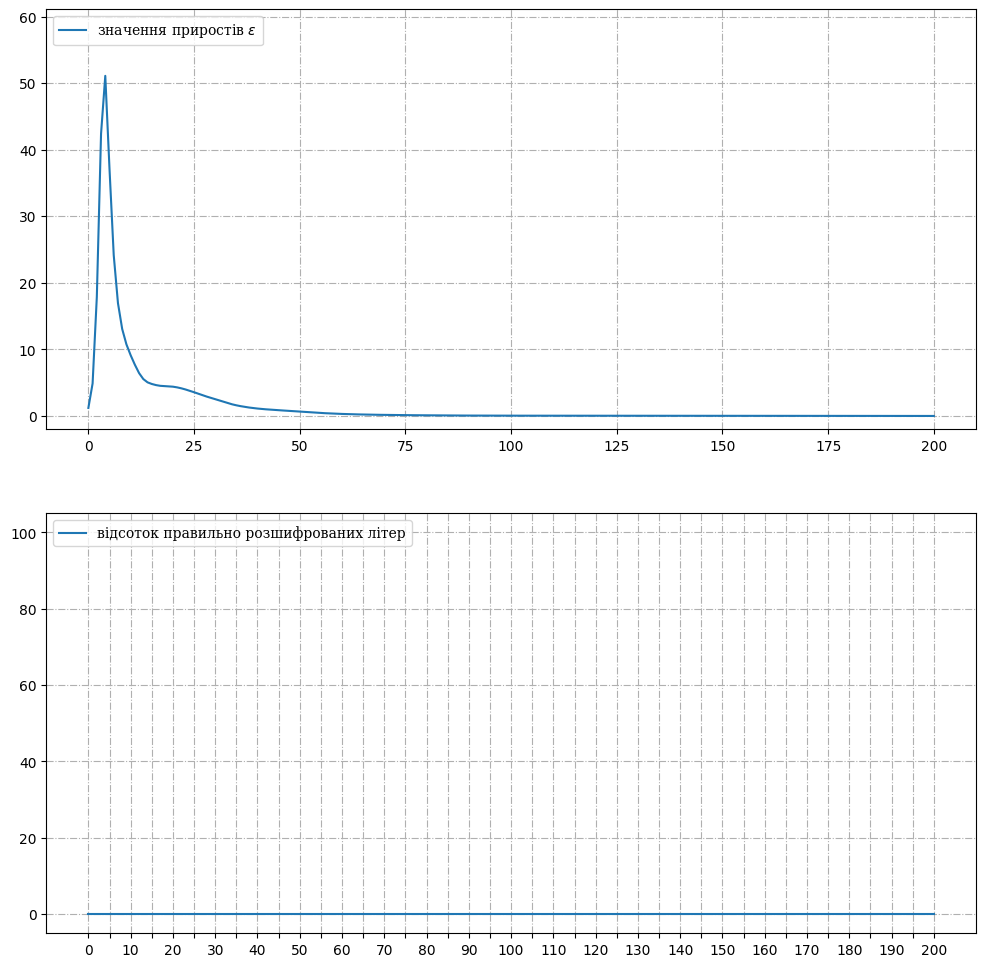

In [76]:
print(len(epsilon), len(d))

print(min(epsilon[100:]), max(d))

font = {
    "family": "serif"
}

plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.plot([i for i in range(len(epsilon))], epsilon)
plt.ylim(-2,max(epsilon)+10)
# plt.ylim(-0.0005,0.001)
plt.legend([r"значення приростів $\varepsilon$"], prop = font, loc = "upper left") # loc = "upper left"
plt.grid(True, linestyle='-.')

# x,y = 167, round(epsilon[167],4)

# plt.annotate(f"A {x,y}", # this is the text
#     (x,y), # these are the coordinates to position the label
#     textcoords="offset points", # how to position the text
#     xytext=(3,5), # distance from text to points (x,y)
#     ha='left', # horizontal alignment can be left, right or center
#     va="bottom", # vertical alignment can be bottom, top or center
# )

# plt.plot(x, y, "o", color = "black")

plt.subplot(2,1,2)
plt.plot([i for i in range(len(d))], [d[i]*100 for i in range(len(d))])

# y = int(d[167]*100)

# plt.annotate(f"A {x,y}", # this is the text
#     (x,y), # these are the coordinates to position the label
#     textcoords="offset points", # how to position the text
#     xytext=(3,5), # distance from text to points (x,y)
#     ha='left', # horizontal alignment can be left, right or center
#     va="bottom", # vertical alignment can be bottom, top or center
# )

# plt.plot(x, y, "o", color = "black")

grid_measure = 5

markers = ["" for i in range(len(d)//grid_measure + 1)]
for i in range(len(markers)):
    if i*grid_measure in [i*10 for i in range(len(d) // 10 + 1)]:
        markers[i] = i*grid_measure

plt.xticks(np.arange(0, len(d)+1, grid_measure), markers)
# plt.yticks(np.arange(0, 110, 10))

plt.ylim(min(d)*100-5,105)
plt.legend([r"відсоток правильно розшифрованих літер"], prop = font, loc = "upper left")
plt.grid(True, linestyle='-.')

plt.show()

- __Алгоритм Вітербі__

In [48]:
def viterbi(y,m,A,B):
    time = len(y)

    delta = [[0.0 for i in range(len(B))] for t in range(time)]
    psi = [[0 for i in range(len(B))] for t in range(time)]

    for t in range(time):
        for i in range(len(B)):
            if t == 0:
                # delta[t][i] = m[i]*B[i][y[t]-1]
                delta[t][i] = np.log(m[i]) + np.log(B[i][y[t]-1])
            else:
                dA = []
                for j in range(len(B)):
                    # dA.append(delta[t-1][j]*A[j][i]*B[i][y[t]-1])
                    dA.append(delta[t-1][j] + np.log(A[j][i]) + np.log(B[i][y[t]-1]))
                delta[t][i] = max(dA)
                psi[t][i] = np.argmax(dA) + 1
    
    x = []
    delta_hat = max(delta[time-1])
    x.append(np.argmax(delta[time-1])+1)

    for t in range(time-2, -1, -1):
        x.insert(0, psi[t+1][x[0]-1])

    return x

In [49]:
def log_viterbi(y,m,A,B):
    time = len(y)
    delta = [[0.0 for i in range(len(B))] for t in range(time)]
    psi = [[0 for i in range(len(B))] for t in range(time)]

    for t in range(time):
        for i in range(len(B)):
            if t == 0: 
                delta[t][i] = np.log(m[i]) + np.log(B[i][y[t]-1])
            else:
                dA = []
                for j in range(len(B)):
                    dA.append(delta[t-1][j] + np.log(A[j][i]))
                delta[t][i] = np.log(B[i][y[t]-1]) + max(dA)
                psi[t][i] = np.argmax(dA) + 1

    # print(delta)
    # print(psi)

    x = []
    delta_hat = max(delta[time-1])
    x.append(np.argmax(delta[time-1])+1)

    for t in range(time-2, -1, -1):
        x.insert(0, psi[t+1][x[0]-1])

    return x

In [50]:
def preprocessing(m,A,B):
    precision = pow(10,-323)

    for i in range(len(m)):
        if m[i] < precision:
            m[i] = precision

    for i in range(len(A)):
        for j in range(len(A[0])):
            if A[i][j] < precision:
                A[i][j] = precision

    for i in range(len(B)):
        for j in range(len(B[0])):
            if B[i][j] < precision:
                B[i][j] = precision
    
    return m,A,B

In [51]:
def file(langauge, x):
    if language == "ENG: 1984":    
        x = decoding(x) # convertion from enumerated states to letters
        text.push(x, "1984 chapters III-VIII: decrypted.txt")
        # text.decrypt("chapters IV-X: encrypted.txt", "chapters IV-X: decrypted.txt", alphabet, key = 3)
        text.insert_spaces("1984 chapters III-VIII: decrypted.txt", "1984 chapters III-VIII: output.txt", removed_spaces)
    else: # language == "UKR: misto"    
        x = ascii.decoding(x) # convertion from enumerated states to letters
        text.push(x, "misto chapters IV-X: decrypted.txt")
        # text.decrypt("chapters IV-X: encrypted.txt", "chapters IV-X: decrypted.txt", alphabet, key = 3)
        text.insert_spaces("misto chapters IV-X: decrypted.txt", "misto chapters IV-X: output.txt", removed_spaces)

- __Інтерфейс алгоритму__

In [68]:
test = y_ciphered

m,A,B = preprocessing(m,A,B)

x = viterbi(test,m,A,B)

file(language, x)